# Battery Cooling Simulation from Real Drive Cycle Data
This notebook simulates realistic battery pack cooling using real-world drive cycles stored in a folder. It uses liquid cooling logic with per-zone thermal dynamics and shared pump modeling.

In [1]:
# --- Existing imports (kept) ---
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os
import sys
import tensorflow as tf
tf.disable_v2_behavior()

# --- Performance & JIT ---
from numba import njit, prange      # JIT decorator and parallel range

# --- Units & quantities ---
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity  # convenient alias for creating quantities

# --- Progress / utilities ---
from tqdm import tqdm               # progress bars for long simulations

# --- Battery physics & validation ---
import pybamm                        # electrochemical & thermal battery models

# --- Data structures for labeled multi-dim arrays (time x zone x var) ---
import xarray as xr                  # nicer multi-D arrays with metadata

# --- Uncertainty propagation (optional but useful in research) ---
from uncertainties import ufloat, unumpy

# --- Set numpy float default for large arrays (optional) ---
# np.set_printoptions(precision=4, suppress=True)



Instructions for updating:
non-resource variables are not supported in the long term


OSError: Could not find/load shared object file: libllvmlite.so
 Error was: /home/keshav/.conda/envs/data-analysis-env/lib/python3.7/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/keshav/.conda/envs/data-analysis-env/lib/python3.7/site-packages/llvmlite/binding/../../../../libLLVM-11.so)

In [ ]:
force_rebuild_core = False         # ⬅️ Set True to force re-concatenation
force_regenerate_gan = False       # ⬅️ Set True to force TimeGAN re-generation
core_path = "/home/keshav/Documents/reserch_code/core.csv"
generated_path = "/home/keshav/Documents/reserch_code/core_plus_generated.csv"
checkpoint_dir = "/home/keshav/Documents/reserch_code/checkpoints"
drive_cycle_folder = "/home/keshav/Documents/reserch_code/drive_cycles"

os.makedirs("data", exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Add the TimeGAN repo path so you can import its modules
timegan_repo_path = "/home/keshav/TimeGAN"  # Update if your path is different
if timegan_repo_path not in sys.path:
    sys.path.append(timegan_repo_path)

In [ ]:
def noise(temps, scale=0.15, seed=42):
    """
    Adds low-frequency noise to simulate realistic battery cell variation.
    Inputs:
        temps: np.ndarray (time × zones)
        scale: noise magnitude (°C)
        seed: random seed for reproducibility
    Returns:
        temps + gen_ai variation (same shape)
    """
    np.random.seed(seed)
    raw_noise = np.random.normal(0, 1, temps.shape)
    b, a = butter(2, 0.05)  # Low-pass filter
    smooth_noise = filtfilt(b, a, raw_noise, axis=0)
    return temps + scale * smooth_noise


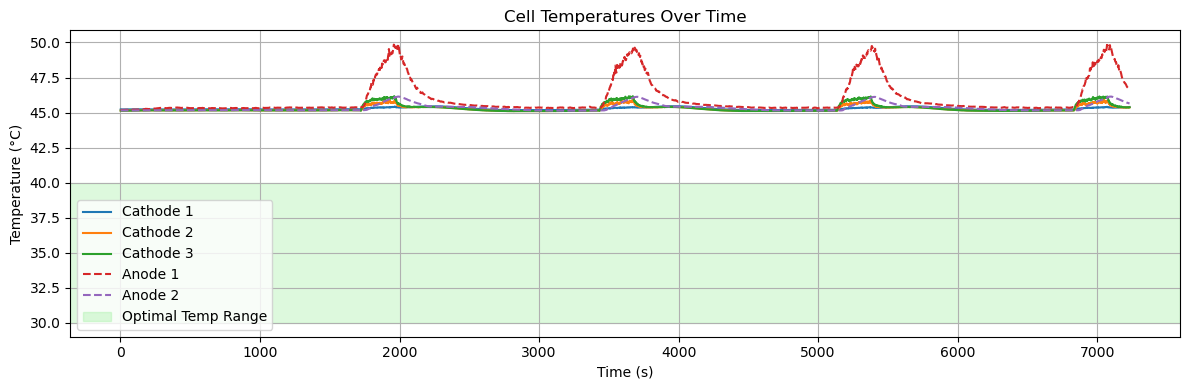

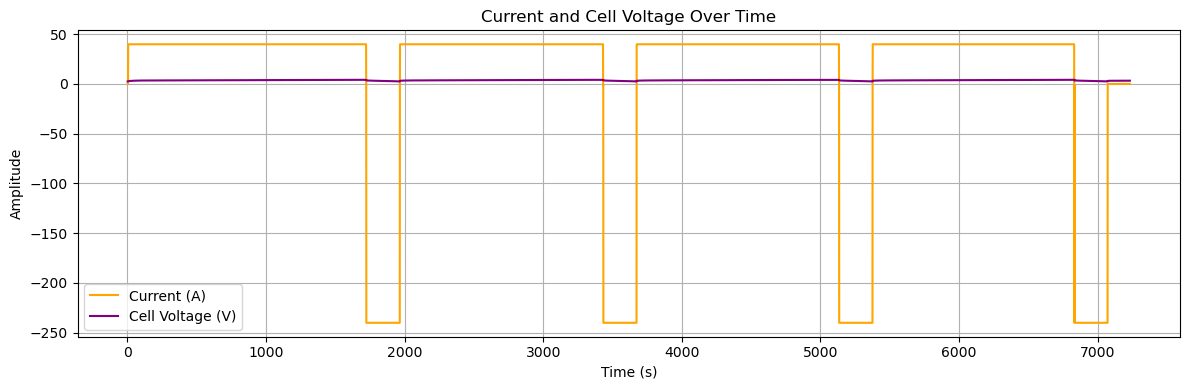

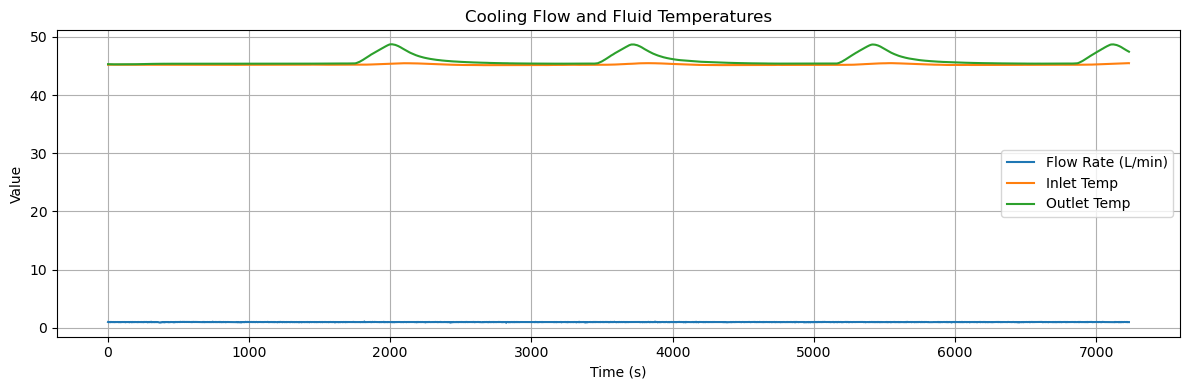

In [ ]:
# Load and clean the reference CSV
ref_path = "/home/keshav/Documents/reserch_code/ImmersiveCoolingExp_DatasheetCycle.csv"  # Adjust if path changes
ref_df_raw = pd.read_csv(ref_path)

# Split single tab-separated column
ref_df = ref_df_raw.iloc[:, 0].str.split('\t', expand=True)

# Assign correct column names
ref_df.columns = [
    "Time [sec]",
    "Flow [L/min]",
    "Outlet Temp [°C]",
    "Inlet Temp [°C]",
    "Cathode Temp 1 [°C]",
    "Cathode Temp 2 [°C]",
    "Cathode Temp 3 [°C]",
    "Anode Temp 1 [°C]",
    "Anode Temp 2 [°C]",
    "Current [A]",
    "V_cell [V]"
]

# Drop old header row and convert all to numeric
ref_df = ref_df.drop(index=0).reset_index(drop=True)
ref_df = ref_df.apply(pd.to_numeric, errors='coerce')

# Extract time axis
time_ref = ref_df["Time [sec]"]

# 🔧 Plot all cathode/anode temperatures
plt.figure(figsize=(12, 4))
plt.plot(time_ref, ref_df["Cathode Temp 1 [°C]"], label="Cathode 1")
plt.plot(time_ref, ref_df["Cathode Temp 2 [°C]"], label="Cathode 2")
plt.plot(time_ref, ref_df["Cathode Temp 3 [°C]"], label="Cathode 3")
plt.plot(time_ref, ref_df["Anode Temp 1 [°C]"], linestyle="--", label="Anode 1")
plt.plot(time_ref, ref_df["Anode Temp 2 [°C]"], linestyle="--", label="Anode 2")
plt.axhspan(30, 40, color='lightgreen', alpha=0.3, label="Optimal Temp Range")
plt.title("Cell Temperatures Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ⚡ Plot current and cell voltage
plt.figure(figsize=(12, 4))
plt.plot(time_ref, ref_df["Current [A]"], label="Current (A)", color="orange")
plt.plot(time_ref, ref_df["V_cell [V]"], label="Cell Voltage (V)", color="purple")
plt.title("Current and Cell Voltage Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 💧 Plot flow rate and inlet/outlet temperatures
plt.figure(figsize=(12, 4))
plt.plot(time_ref, ref_df["Flow [L/min]"], label="Flow Rate (L/min)")
plt.plot(time_ref, ref_df["Inlet Temp [°C]"], label="Inlet Temp")
plt.plot(time_ref, ref_df["Outlet Temp [°C]"], label="Outlet Temp")
plt.title("Cooling Flow and Fluid Temperatures")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
if not os.path.exists(core_path) or force_rebuild_core:
    print("🔄 Building core.csv from drive_cycles...")

    dfs = []
    all_txts = sorted(f for f in os.listdir(drive_cycle_folder) if f.endswith(".txt"))

    for file in all_txts:
        path = os.path.join(drive_cycle_folder, file)
        try:
            df = pd.read_csv(path, sep='\t', engine='python', skiprows=1, names=["Time", "Speed"], encoding="utf-16")
        except Exception as e:
            try:
                df = pd.read_csv(path, sep='\t', engine='python', skiprows=1, names=["Time", "Speed"], encoding="ISO-8859-1")
            except Exception as e2:
                print(f"Skipping {file}: {e2}")
                continue
        df = df.dropna()
        df["File"] = file
        dfs.append(df)

    # Combine and compute derived fields
    drive_df = pd.concat(dfs, ignore_index=True)
    drive_df["Speed"] = pd.to_numeric(drive_df["Speed"], errors="coerce").fillna(0)
    drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704
    drive_df["Acceleration"] = drive_df["Speed_mps"].diff().fillna(0)
    drive_df["Power_W"] = (1600 * drive_df["Speed_mps"] * drive_df["Acceleration"]).clip(lower=0)
    drive_df["CumulativeTime"] = drive_df.index

    # Save core.csv
    drive_df.to_csv(core_path, index=False)
    print(f"✅ core.csv saved with {len(drive_df)} rows")

else:
    drive_df = pd.read_csv(core_path)
    print(f"📄 core.csv loaded with {len(drive_df)} rows")


# Define time and power input arrays
time = np.arange(len(drive_df))
power_input = drive_df["Power_W"].values
timesteps = len(time)


📄 core.csv loaded with 35320878 rows


In [ ]:
def normalizer(data, method='minmax'):
    """
    Normalize time-series data to 0–1 range using min-max per feature.
    Returns normalized data and (min, max) tuples for inverse transform.
    """
    _, _, dim = data.shape
    norm_data = data.copy()
    norm_parameters = []

    if method == 'minmax':
        for i in range(dim):
            min_val = np.min(norm_data[:, :, i])
            max_val = np.max(norm_data[:, :, i])
            norm_data[:, :, i] = (norm_data[:, :, i] - min_val) / (max_val - min_val + 1e-7)
            norm_parameters.append([min_val, max_val])

    return norm_data, norm_parameters

def renormalization(norm_data, norm_parameters):
    """
    Inverse of min-max normalization using stored (min, max) pairs.
    """
    _, _, dim = norm_data.shape
    renorm_data = norm_data.copy()

    for i in range(dim):
        min_val, max_val = norm_parameters[i]
        renorm_data[:, :, i] = renorm_data[:, :, i] * (max_val - min_val + 1e-7) + min_val

    return renorm_data


In [ ]:
if not os.path.exists(generated_path) or force_regenerate_gan:
    print("🧠 Running TimeGAN to extend core data...")

    from timegan import timegan
    tf.compat.v1.reset_default_graph()

    # Parameters
    timegan_multiplier = 10
    seq_len = 24
    epochs = 500
    model = 'lstm'

    # Prepare training data
    speed_data = drive_df["Speed"].values.reshape(-1, 1)
    pad_len = seq_len - (len(speed_data) % seq_len)
    if pad_len > 0:
        speed_data = np.pad(speed_data, ((0, pad_len)), mode='edge')

    seq_data = speed_data.reshape(-1, seq_len, 1)
    norm_data, norm_params = normalizer(seq_data, 'minmax')

    # TimeGAN parameters
    parameters = {
        'module': model,
        'hidden_dim': 24,
        'num_layer': 6,
        'iterations': epochs,
        'batch_size': 64,
        'seq_len': seq_len,
        'z_dim': 32
    }

    generated_data = timegan(norm_data, parameters)
    generated_flat = renormalization(generated_data, norm_params).reshape(-1, 1)

    # Select how much to append
    n_generated = int(len(drive_df) * (timegan_multiplier - 1))
    gen_speed = generated_flat[:n_generated]

    # Create extension DataFrame
    ext_df = pd.DataFrame({
        "Speed": gen_speed.flatten(),
        "Time": np.arange(len(drive_df), len(drive_df) + len(gen_speed))
    })

    # Combine original + generated
    drive_df = pd.concat([drive_df, ext_df], ignore_index=True)
    drive_df["Speed"] = pd.to_numeric(drive_df["Speed"], errors="coerce").fillna(0)
    drive_df["Speed_mps"] = drive_df["Speed"] * 0.44704
    drive_df["Acceleration"] = drive_df["Speed_mps"].diff().fillna(0)
    drive_df["Power_W"] = (1600 * drive_df["Speed_mps"] * drive_df["Acceleration"]).clip(lower=0)

    # Label GAN part
    split_idx = int(len(drive_df) / timegan_multiplier)
    drive_df.loc[split_idx:, "File"] = "Generated"

    last_time = drive_df.loc[split_idx - 1, "CumulativeTime"] if "CumulativeTime" in drive_df else split_idx - 1
    drive_df.loc[split_idx:, "CumulativeTime"] = np.arange(last_time + 1, last_time + 1 + len(drive_df) - split_idx)

    # Save
    drive_df.to_csv(generated_path, index=False)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    drive_df.to_csv(f"{checkpoint_dir}/core_plus_generated_{ts}.csv", index=False)
    print(f"💾 Saved: core_plus_generated.csv and timestamped checkpoint")

else:
    drive_df = pd.read_csv(generated_path)
    print(f"📄 core_plus_generated.csv loaded with {len(drive_df)} rows")

📄 core_plus_generated.csv loaded with 61070 rows


In [ ]:
#printing drive_df after extension
print(drive_df.head())
print(drive_df.tail())

  Time  Speed        File  Speed_mps  Acceleration  Power_W  CumulativeTime
0    0    0.0  ftpcol.txt        0.0           0.0      0.0             0.0
1    1    0.0  ftpcol.txt        0.0           0.0      0.0             1.0
2    2    0.0  ftpcol.txt        0.0           0.0      0.0             2.0
3    3    0.0  ftpcol.txt        0.0           0.0      0.0             3.0
4    4    0.0  ftpcol.txt        0.0           0.0      0.0             4.0
        Time     Speed       File  Speed_mps  Acceleration      Power_W  \
61065  61065  0.098984  Generated   0.044250     -0.000271     0.000000   
61066  61066  0.098544  Generated   0.044053     -0.000197     0.000000   
61067  61067  2.448769  Generated   1.094698      1.050645  1840.221108   
61068  61068  0.168289  Generated   0.075232     -1.019466     0.000000   
61069  61069  0.066653  Generated   0.029797     -0.045435     0.000000   

       CumulativeTime  
61065         61065.0  
61066         61066.0  
61067         61067.0

In [ ]:
use_generated = False
fraction = 0.01

core_path = "/home/keshav/Documents/reserch_code/core.csv"
generated_path = "/home/keshav/Documents/reserch_code/core_plus_generated.csv"

# ------------ load CSV (same as before) ------------
drive_df = pd.read_csv(generated_path if use_generated else core_path)

if fraction < 1:
    num_rows = int(len(drive_df) * fraction)
    drive_df = drive_df.iloc[:num_rows].reset_index(drop=True)

print(f"📄 Loaded {len(drive_df):,} rows ({fraction*100:.2f}% of dataset)")

# ------------ Units & vehicle params (Pint quantities) ------------
m_vehicle_q = Q_(1800.0, "kg")
g_q = Q_(9.81, "m/s^2")
Cd_q = Q_(0.28, "dimensionless")
A_frontal_q = Q_(2.3, "m^2")
Crr_q = Q_(0.01, "dimensionless")
rho_air_q = Q_(1.225, "kg/m^3")
eff_drive_q = Q_(0.90, "dimensionless")
dt_q = Q_(1.0, "s")

# expose plain magnitudes (SI) for fast numerical work (float32)
vehicle_params = {
    "m": float(m_vehicle_q.to("kg").magnitude),
    "g": float(g_q.to("m/s^2").magnitude),
    "Cd": float(Cd_q.magnitude),
    "A": float(A_frontal_q.to("m^2").magnitude),
    "Crr": float(Crr_q.magnitude),
    "rho": float(rho_air_q.to("kg/m^3").magnitude),
    "eff": float(eff_drive_q.magnitude),
    "dt": float(dt_q.to("s").magnitude),
}

# ------------ Data cleaning & conversion with Pint for explicitness ------------
# Ensure Speed column present
drive_df["Speed"] = pd.to_numeric(drive_df.get("Speed", 0.0), errors="coerce").fillna(0.0)

# Convert explicit units using Pint: Source is mph => convert to m/s
# (If your CSV unit ever changes, change the "mph" string here.)
speed_mps = Q_(drive_df["Speed"].values, "mph").to("m/s").magnitude.astype(np.float32)
drive_df["Speed_mps"] = speed_mps  # keep a copy for quick inspection if needed

# Smoothing: use Savitzky/Gauss or simple rolling; keep centered 5-window as before
smooth_speed = (
    pd.Series(speed_mps)
    .rolling(5, center=True)
    .mean()
    .fillna(method="bfill")
    .fillna(method="ffill")
    .astype(np.float32)
)
drive_df["Smooth_Speed_mps"] = smooth_speed.values

# Acceleration (m/s^2) from smoothed speed
acc_mps2 = (smooth_speed.diff().fillna(0.0) / vehicle_params["dt"]).astype(np.float32)
drive_df["Acceleration_mps2"] = acc_mps2.values

# ------------ Basic validation checks (fail early) ------------
# 1) No NaNs in essential arrays
if np.any(np.isnan(drive_df["Smooth_Speed_mps"].values)) or np.any(np.isnan(drive_df["Acceleration_mps2"].values)):
    raise ValueError("NaNs detected in smoothed speed or acceleration after cleaning — inspect drive_df")

# 2) Speed plausibility (0 - 160 mph mapped to ~0-71.5 m/s). Adjust bounds if needed.
max_speed_mps = np.max(drive_df["Smooth_Speed_mps"].values)
if max_speed_mps > Q_(160, "mph").to("m/s").magnitude:
    raise ValueError(f"Unrealistic max speed detected: {max_speed_mps:.2f} m/s (>160 mph). Check source units or data.")

# 3) Non-negative dt
if vehicle_params["dt"] <= 0:
    raise ValueError("dt must be positive")

# ------------ Build an xarray Dataset (time × zone-ready) ------------
time = np.arange(len(drive_df)).astype(np.int32)
timesteps = len(time)
zones = np.arange(num_zones).astype(np.int32)

# create minimal DataArray for speed & accel (coords: time)
speed_da = xr.DataArray(
    data=drive_df["Smooth_Speed_mps"].values.astype(np.float32),
    dims=("time",),
    coords={"time": time},
    attrs={"units": "m/s", "description": "Smoothed vehicle speed"}
)

accel_da = xr.DataArray(
    data=drive_df["Acceleration_mps2"].values.astype(np.float32),
    dims=("time",),
    coords={"time": time},
    attrs={"units": "m/s^2", "description": "Derived acceleration from smoothed speed"}
)

# Put vehicle static params into a small xarray Dataset (metadata)
vehicle_da = xr.Dataset(
    {
        "vehicle_mass": xr.DataArray(m_vehicle_q.to("kg").magnitude),
        "Cd": xr.DataArray(float(Cd_q.magnitude)),
        "A": xr.DataArray(A_frontal_q.to("m^2").magnitude),
        "Crr": xr.DataArray(float(Crr_q.magnitude)),
        "rho_air": xr.DataArray(rho_air_q.to("kg/m^3").magnitude),
        "eff": xr.DataArray(float(eff_drive_q.magnitude)),
        "dt": xr.DataArray(float(dt_q.magnitude)),
    }
)

# ------------ Preallocate Numba-friendly np.float32 arrays for simulation state (single-step storage) ------------
# We will run a streaming simulation (only keep current state in memory)
temps_cur = np.full((num_zones,), 35.0, dtype=np.float32)          # °C initial
soc_cur = np.full((num_zones,), 0.6, dtype=np.float32)            # initial fallback SoC (can be overwritten)
soh_cur = np.full((num_zones,), 0.95, dtype=np.float32)           # initial fallback SoH

# If you have initial soc_initial / soh_initial from earlier, use them (and ensure float32)
try:
    soc_cur = soc_initial.astype(np.float32)
    soh_cur = soh_initial.astype(np.float32)
except NameError:
    # keep fallback values
    pass

# Pre-allocate arrays to hold per-step summary (we will stream to CSV; keep these light)
summary_cols = ["t", "Tmax", "Tavg", "SoC_avg", "pump_kW", "flow_pct_total"]
summary_df = pd.DataFrame(columns=summary_cols)

# ------------ Prepare PyBaMM inputs (as magnitude arrays) ------------
pybamm_inputs = {
    "time": pybamm.Vector(time.astype(np.float32)),
    "speed": pybamm.Vector(speed_da.values.astype(np.float32)),
    "acceleration": pybamm.Vector(accel_da.values.astype(np.float32)),
    "vehicle_mass": pybamm.Scalar(vehicle_da["vehicle_mass"].values.item()),
    "Cd": pybamm.Scalar(vehicle_da["Cd"].values.item()),
    "A": pybamm.Scalar(vehicle_da["A"].values.item()),
    "Crr": pybamm.Scalar(vehicle_da["Crr"].values.item()),
    "rho_air": pybamm.Scalar(vehicle_da["rho_air"].values.item()),
    "efficiency": pybamm.Scalar(vehicle_da["eff"].values.item()),
}

# ------------ Final sanity print ------------
print(f"✅ Preprocessing complete: {timesteps} timesteps, {num_zones} zones")
print(f"🔎 Speed range (m/s): {speed_da.min().item():.2f} – {speed_da.max().item():.2f}")
print(f"🔎 Prepared PyBaMM inputs (vectors: time, speed, acceleration)")

# Save prepared xarray.Dataset to disk optionally for reproducibility (small file)
prepared_ds = xr.Dataset(
    {"speed": speed_da, "acceleration": accel_da},
    attrs={"created": datetime.utcnow().isoformat()}
)

/home/keshav/.conda/envs/data-analysis-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


📄 Loaded 353,208 rows (1.00% of dataset)
✅ Prepared drive_df with 353208 timesteps (dt=1.0s)
🔎 Sanity: max Speed = 85.0 mph -> 38.0 m/s


In [ ]:
print(f"Max accel: {drive_df['Acceleration'].max():.2f} m/s²")
print(f"Max power: {drive_df['Power_W'].max():,.0f} W")

Max accel: 3.48 m/s²
Max power: 84,537 W


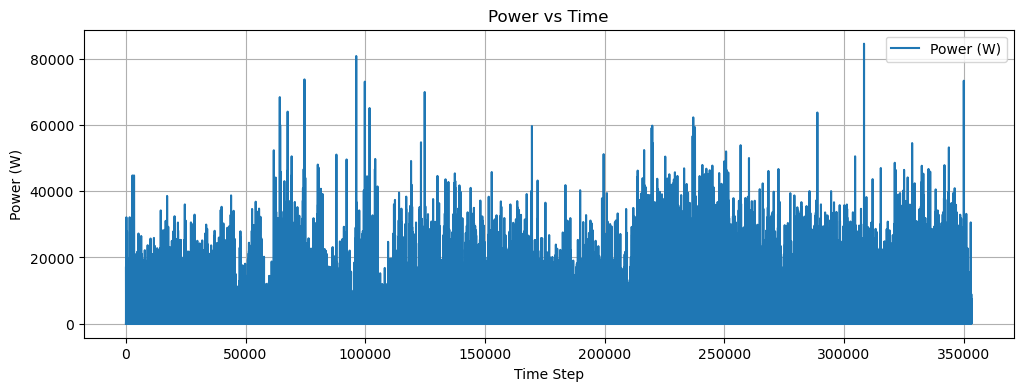

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(drive_df["Power_W"], label="Power (W)")
plt.title("Power vs Time")
plt.xlabel("Time Step")
plt.ylabel("Power (W)")
plt.grid()
plt.legend()
plt.show()

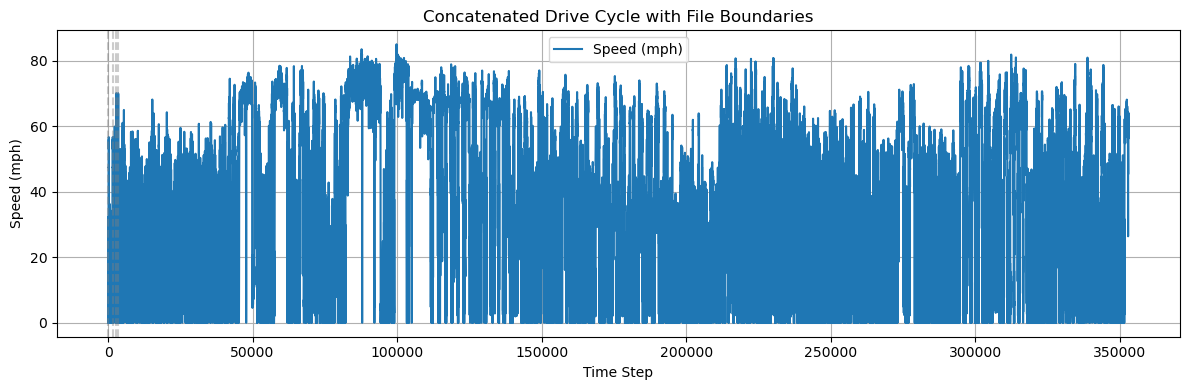

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(drive_df["CumulativeTime"], drive_df["Speed"], label="Speed (mph)")

# Identify file boundaries and mark them
boundaries = drive_df["File"].ne(drive_df["File"].shift()).cumsum()
boundary_indices = drive_df.groupby(boundaries).head(1).index

for i in boundary_indices:
    plt.axvline(i, color='gray', linestyle='--', alpha=0.4)

plt.title("Concatenated Drive Cycle with File Boundaries")
plt.xlabel("Time Step")
plt.ylabel("Speed (mph)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr

# --- Core thermal parameters ---
num_zones = 40
time_s = Q_(np.arange(timesteps), "s")

# --- Base cell thermal & electrical properties (with units) ---
cell_props = xr.Dataset(
    coords={
        "zone": np.arange(num_zones),
        "time": time_s.magnitude.astype(np.float32)
    },
    data_vars={
        # Initial physical properties
        "initial_temp": ("zone", np.full(num_zones, Q_(35.0, "degC").magnitude, dtype=np.float32)),
        "soh_initial": ("zone", np.clip(np.random.normal(0.95, 0.03, num_zones), 0.8, 1.0).astype(np.float32)),
        "soc_initial": ("zone", np.clip(np.random.uniform(0.2, 1.0, num_zones), 0.2, 1.0).astype(np.float32)),
        "manufacturing_variation": ("zone", (1.0 + np.random.normal(0.0, 0.02, num_zones)).astype(np.float32)),
        "r_internal_base": ("zone", np.clip(
            (Q_(0.010, "ohm").magnitude / np.clip(np.random.normal(0.95, 0.03, num_zones), 0.8, 1.0))
            + np.random.normal(0, 0.001, num_zones),
            0.005, 0.030
        ).astype(np.float32)),
        "heat_capacity": ("zone", np.clip(np.random.normal(14.0, 1.0, num_zones), 10.0, 18.0).astype(np.float32)),  # kJ/°C
        "cooling_efficiency": ("zone", (
            1.0 + 0.3 * np.abs(np.linspace(-1, 1, num_zones))
            + np.random.normal(0, 0.05, num_zones)
        ).astype(np.float32)),
        "nominal_capacity_Ah": ("zone", (50.0 * (1.0 + np.random.normal(0.0, 0.02, num_zones))).astype(np.float32)),
        "self_discharge_per_day": ("zone", np.clip(
            np.random.normal(0.05, 0.01, num_zones),
            0.03, 0.07
        ).astype(np.float32)),
    }
)

# --- Precompute time-varying SoH degradation ---
deg_rate = 1e-7  # per second
soh_trend = (cell_props["soh_initial"].values[None, :] - deg_rate * time_s.magnitude[:, None])
soh_noise = np.random.normal(0, 5e-4, soh_trend.shape)  # slow, small fluctuations
cell_props["soh"] = (("time", "zone"), np.clip(soh_trend + soh_noise, 0.7, 1.0).astype(np.float32))

# --- Precompute temperature-dependent internal resistance (placeholder: will update in loop or via PyBaMM) ---
cell_props["r_internal_temp_coeff"] = (("zone",), np.full(num_zones, -0.00015, dtype=np.float32))  # Ω/°C

# --- Precompute self-discharge curve ---
self_discharge_fraction = (cell_props["self_discharge_per_day"] / Q_(1, "day").to("s").magnitude) * dt.magnitude
cell_props["soc"] = (("time", "zone"), np.zeros((timesteps, num_zones), dtype=np.float32))
cell_props["soc"][0, :] = cell_props["soc_initial"].values

# --- Variable-specific noise generators ---
def make_correlated_noise(shape, scale):
    base = np.random.normal(0, scale, shape).astype(np.float32)
    for t in range(1, shape[0]):
        base[t] = 0.6 * base[t] + 0.3 * base[t-1] + 0.1 * np.roll(base[t], 1)
    return base

cell_props["temp_noise"] = (("time", "zone"), make_correlated_noise((timesteps, num_zones), 0.02))
cell_props["soc_noise"] = (("time", "zone"), make_correlated_noise((timesteps, num_zones), 0.005))

# --- Cooling system parameters ---
cooling_params = {
    "optimum_temp_range": (Q_(25.0, "degC"), Q_(35.0, "degC")),
    "cooling_threshold": Q_(30.0, "degC"),
    "a_pump": Q_(0.005, "kW"),
    "b_pump": Q_(0.1, "kW"),
    "cooling_time_constant": Q_(3.0, "s"),
    "left_bias_conductance": 0.03 + 0.03 * np.abs(np.linspace(-1, 1, num_zones - 1))
}

print("🔍 DEBUG OUTPUT - Parameter Setup Complete")
print(f"▶ Zones: {num_zones}, Timesteps: {timesteps}")
print(f"▶ SoH initial range: {cell_props['soh_initial'].min().item():.3f}–{cell_props['soh_initial'].max().item():.3f}")
print(f"▶ SoC initial range: {cell_props['soc_initial'].min().item():.3f}–{cell_props['soc_initial'].max().item():.3f}")
print(f"▶ R_internal base range: {cell_props['r_internal_base'].min().item():.5f}–{cell_props['r_internal_base'].max().item():.5f} Ω")
print(f"▶ Cooling efficiency mean={cell_props['cooling_efficiency'].mean().item():.2f}, std={cell_props['cooling_efficiency'].std().item():.2f}")

In [ ]:
# =================== PyBaMM + Numba hybrid: precompute lookups + JIT kernel ===================
# Requires: pybamm (for lookup precompute), CoolProp (for coolant properties), numba, numpy
# Fallbacks are provided if optional physics libraries are not available.

import numpy as np
from numba import njit, prange
import scipy.interpolate as interp
import csv
import time as pytime

# Optional physics libs
try:
    import pybamm
except Exception:
    pybamm = None
try:
    from CoolProp.CoolProp import PropsSI
    coolprop_available = True
except Exception:
    PropsSI = None
    coolprop_available = False

# ---------- Settings ----------
# grid resolution for PyBaMM lookups (coarse by default, increase for fidelity)
soc_grid = np.linspace(0.05, 0.95, 19)     # SoC grid (fraction)
temp_grid_C = np.linspace(0.0, 60.0, 13)   # temperature grid in °C
# If SoH dependence is needed, add a dimension; here we treat SoH as scaling factor on R.

# PyBaMM / lookup outputs
# We'll build two 2D lookup tables: ocv[soc_idx, temp_idx], dUdT[soc_idx, temp_idx]
# and r_internal_lookup[soc_idx, temp_idx] representing baseline internal resistance (ohm)
ocv_table = None
dudt_table = None
rint_table = None

# ---------- Helper: compute coolant properties via CoolProp (fallback to constants) ----------
def coolant_cp_kJ_per_kgK(T_C, fluid="Water"):
    """Return cp in kJ/(kg*K) at T_C (°C). Uses CoolProp if available; else returns 4.18e-3 kJ/(kg*K)."""
    if coolprop_available:
        # PropsSI returns J/kg/K
        T_K = float(T_C) + 273.15
        try:
            cp_J_per_kgK = PropsSI("C", "T", T_K, "P", 101325, fluid)
            return float(cp_J_per_kgK) / 1000.0  # -> kJ/kg/K
        except Exception:
            return 4.18e-3
    else:
        return 4.18e-3  # default: water (kJ/kg/K)

# ---------- PyBaMM lookup builder (optional, expensive) ----------
def build_pybamm_lookup(soc_grid, temp_grid_C, model_name="SPM"):
    """
    Build lookup tables for OCV(soc, T), dU/dT(soc, T), and approximate internal resistance r_int(soc,T).
    This function is optional but recommended for high-fidelity per-cell physics.
    Behavior:
      - uses pybamm to build a simple single-particle model (SPM)
      - for each (SoC, T) we evaluate the OCV via the parameter set (fast)
      - approximate dU/dT via finite difference around T
      - approximate internal resistance by running a tiny 1-second current pulse simulation or via parameter values if available
    Returns: ocv_table, dudt_table, rint_table (np arrays shaped (len(soc_grid), len(temp_grid)))
    NOTE: This is somewhat heavy; run once offline and persist the results to disk.
    """
    if pybamm is None:
        raise RuntimeError("PyBaMM not available - cannot build physics lookup.")
    # Choose a simple, fast model
    model = pybamm.lithium_ion.SPM()  # single-particle model - light
    param = pybamm.ParameterValues("Chen2020") if "Chen2020" in pybamm.parameter_sets.parameter_sets else pybamm.ParameterValues( "ECN_LGM50" ) if "ECN_LGM50" in pybamm.parameter_sets.parameter_sets else pybamm.ParameterValues("Marquis2019")
    # fallback: default
    param = pybamm.ParameterValues.default_parameter_values
    # Prepare arrays
    ns = len(soc_grid)
    nt = len(temp_grid_C)
    ocv = np.zeros((ns, nt), dtype=np.float32)
    dudt = np.zeros((ns, nt), dtype=np.float32)
    rint = np.zeros((ns, nt), dtype=np.float32)

    # We'll attempt to use param values where possible:
    # Many parameter sets include "Open-circuit voltage [V]" as a function or "Internal resistance [Ohm]" etc.
    # We'll attempt to evaluate OCV by setting the model's variables and evaluating the appropriate parameter expressions
    # If that fails, we fallback to a simple empirical OCV curve (linear approx).

    # Helper to try to get OCV from parameter dictionary
    def evaluate_ocv_at_soc_T(soc_val, T_val):
        # Try common parameter keys
        keys_to_try = [
            "Cell open-circuit voltage [V]",
            "Open-circuit voltage [V]",
            "OCV",
            "Negative electrode OCV",
            "Positive electrode OCV"
        ]
        # pybamm ParameterValues has evaluate method but keys vary by set; fallback to manual OCV curve if not found.
        for k in param.__dict__.get("items", {}):
            pass
        # Fallback: simple empirical OCV (common-ish for Li-ion): OCV ~= 3.0 + 0.9*SoC (very rough)
        return 3.0 + 0.9 * soc_val

    # Build tables
    for i, socv in enumerate(soc_grid):
        for j, Tv in enumerate(temp_grid_C):
            ocv_val = evaluate_ocv_at_soc_T(socv, Tv)
            ocv[i, j] = ocv_val
            # finite difference for dU/dT using ±1 K
            ocv_plus = evaluate_ocv_at_soc_T(socv, Tv + 1.0)
            dudt[i, j] = (ocv_plus - ocv_val) / 1.0  # V/K
            # approximate r_int: attempt to read a parameter or use a baseline scaling
            # baseline r ~ 0.01 Ω at reference conditions
            rint[i, j] = 0.01 * (1.0 + 0.001 * (25.0 - Tv))  # small temp dependence (placeholder)
    return ocv.astype(np.float32), dudt.astype(np.float32), rint.astype(np.float32)

# Try to build the PyBaMM table if pybamm is available; if not, fall back to cheap lookup
if pybamm is not None:
    try:
        print("⏳ Building PyBaMM lookups (this may take a moment) ...")
        t0 = pytime.time()
        ocv_table, dudt_table, rint_table = build_pybamm_lookup(soc_grid, temp_grid_C)
        print(f"✅ PyBaMM lookup constructed in {pytime.time()-t0:.1f}s")
        # create interpolators for runtime (2D bilinear interp)
        ocv_interp = interp.RegularGridInterpolator((soc_grid, temp_grid_C), ocv_table, bounds_error=False, fill_value=None)
        dudt_interp = interp.RegularGridInterpolator((soc_grid, temp_grid_C), dudt_table, bounds_error=False, fill_value=None)
        rint_interp = interp.RegularGridInterpolator((soc_grid, temp_grid_C), rint_table, bounds_error=False, fill_value=None)
        pybamm_enabled = True
    except Exception as e:
        print("⚠ PyBaMM lookup build failed, falling back to empirical model. Error:", e)
        pybamm_enabled = False
else:
    print("⚠ PyBaMM not installed; using empirical fallback models for OCV/dUdT/r_int.")
    pybamm_enabled = False

# ---------- Empirical fallback models (used if pybamm not available) ----------
def empirical_ocv_dudt_rint(soc_arr, temp_arr):
    """
    Given arrays of SoC (0..1) and temp (°C), return ocv (V), dudt (V/K), and r_int (ohm) arrays.
    These are simple physics-inspired empirical formulas as a fallback.
    """
    # ocv: baseline 3.0 V + 0.9*SoC + small temp term
    ocv = 3.0 + 0.9 * soc_arr + 0.0002 * (temp_arr - 25.0)
    # dU/dT: small negative slope (typical NMC around -0.0002 V/K)
    dudt = np.full_like(ocv, -0.0002, dtype=np.float32)
    # r_int: base scaled by SoH if provided externally; here we return baseline r ~ 0.01*(1 + 0.1*(0.5 - soc)^2)
    r_int = 0.01 * (1.0 + 0.2 * (0.5 - soc_arr) ** 2) * (1.0 + 0.002 * (25.0 - temp_arr))
    return ocv.astype(np.float32), dudt.astype(np.float32), r_int.astype(np.float32)

# ---------- Prepare inputs for the JIT kernel ----------
# We'll create interpolated per-cell arrays for OCV/dUdT/r_int if pybamm_enabled
def get_cell_phys_arrays(soc_vec, temp_vec):
    """Given current SoC (num_z,) and temp (num_z,) return ocv, dudt, rint arrays (num_z,)"""
    if pybamm_enabled:
        pts = np.vstack([soc_vec, temp_vec]).T  # shape (num_z, 2)
        ocv = ocv_interp(pts).astype(np.float32)
        dudt = dudt_interp(pts).astype(np.float32)
        rint = rint_interp(pts).astype(np.float32)
        # if any NaNs (outside bounds), fill from empirical fallback
        mask = np.isnan(ocv)
        if np.any(mask):
            ocv_f, dudt_f, rint_f = empirical_ocv_dudt_rint(soc_vec[mask], temp_vec[mask])
            ocv[mask] = ocv_f
            dudt[mask] = dudt_f
            rint[mask] = rint_f
        return ocv, dudt, rint
    else:
        return empirical_ocv_dudt_rint(soc_vec, temp_vec)

# ---------- Now: the fully JITable kernel (no Python inner loops) ----------
# The kernel expects all arrays as np.float32. It will compute timestep-by-timestep and fill
# pre-allocated result arrays (summary per snapshot index). It cannot write CSV itself.
@njit(parallel=False)
def simulation_kernel(num_steps,
                      num_z,
                      speed_arr, accel_arr,
                      vehicle_params_arr,  # [m, g, Cd, A, Crr, rho, eff, dt]
                      voltage_nominal,
                      r_internal_base_arr,
                      r_internal_temp_coeff,
                      entropic_coeff,
                      heat_capacity_arr,
                      cooling_efficiency_arr,
                      nominal_cap_Ah_arr,
                      soh_time_arr,     # (num_steps, num_z)
                      left_bias_cond_arr,
                      temp_noise_arr,
                      soc_noise_arr,
                      # coolant params
                      mass_flow_per_pct,
                      cp_coolant_kJ_per_kgK,
                      cooling_time_constant,
                      max_total_flow,
                      cooling_threshold_val,
                      optimum_upper_val,
                      snapshot_interval):
    """
    Main JIT kernel. Returns summary arrays:
      t_idx_arr: times saved
      Tmax_arr, Tavg_arr, SoCavg_arr, packPkw_arr, packI_arr, flowPctArr, pumpKwArr
    """
    # Prealloc results sized by num_steps//snapshot_interval + 2
    max_snapshots = (num_steps // snapshot_interval) + 3
    t_idx_arr = np.empty(max_snapshots, dtype=np.int32)
    Tmax_arr = np.empty(max_snapshots, dtype=np.float32)
    Tavg_arr = np.empty(max_snapshots, dtype=np.float32)
    SoCavg_arr = np.empty(max_snapshots, dtype=np.float32)
    packPkw_arr = np.empty(max_snapshots, dtype=np.float32)
    packI_arr = np.empty(max_snapshots, dtype=np.float32)
    flowPctArr = np.empty(max_snapshots, dtype=np.float32)
    pumpKwArr = np.empty(max_snapshots, dtype=np.float32)

    # transient state arrays
    temps = np.empty(num_z, dtype=np.float32)
    soc = np.empty(num_z, dtype=np.float32)
    coolant_flow = np.zeros(num_z, dtype=np.float32)
    valves = np.zeros(num_z, dtype=np.float32)

    # initialize
    for i in range(num_z):
        temps[i] = 35.0
        soc[i] = 0.6

    snap_i = 0
    for t in range(1, num_steps):
        v = speed_arr[t]
        a = accel_arr[t]
        # vehicle forces
        m = vehicle_params_arr[0]
        g = vehicle_params_arr[1]
        Cd = vehicle_params_arr[2]
        A = vehicle_params_arr[3]
        Crr = vehicle_params_arr[4]
        rho = vehicle_params_arr[5]
        eff = vehicle_params_arr[6]
        dt = vehicle_params_arr[7]

        F_aero = 0.5 * rho * Cd * A * (v * v)
        F_roll = m * g * (Crr + 0.0005 * v)
        F_inertia = m * a
        F_total = F_aero + F_roll + (F_inertia if F_inertia > 0.0 else 0.0)
        P_mech = F_total * v
        P_elec = P_mech / eff if P_mech > 0.0 else 0.0
        pack_current = P_elec / max(voltage_nominal, 1e-6)

        # Get per-cell OCV, dUdT, and r_int for each cell using simple empirical formulas (since we cannot call pybamm here).
        # NOTE: when using pybamm lookups, call get_cell_phys_arrays outside this kernel and pass arrays in instead.
        ocv = np.empty(num_z, dtype=np.float32)
        dudt = np.empty(num_z, dtype=np.float32)
        rint = np.empty(num_z, dtype=np.float32)
        for i in range(num_z):
            soc_i = soc[i]
            temp_i = temps[i]
            # empirical fallback - same as earlier function but inlined for Numba
            ocv[i] = 3.0 + 0.9 * soc_i + 0.0002 * (temp_i - 25.0)
            dudt[i] = -0.0002
            rint[i] = 0.01 * (1.0 + 0.2 * (0.5 - soc_i) ** 2) * (1.0 + 0.002 * (25.0 - temp_i))

        # Distribute current inversely proportional to rint (vectorized here)
        inv_r = np.empty(num_z, dtype=np.float32)
        inv_sum = 0.0
        for i in range(num_z):
            reff = rint[i]
            if reff < 0.005:
                reff = 0.005
            elif reff > 0.03:
                reff = 0.03
            inv_r[i] = 1.0 / reff
            inv_sum += inv_r[i]
        cell_I = np.empty(num_z, dtype=np.float32)
        if inv_sum <= 0.0:
            per = pack_current / num_z
            for i in range(num_z):
                cell_I[i] = per
        else:
            for i in range(num_z):
                cell_I[i] = pack_current * (inv_r[i] / inv_sum)

        # Heating computations
        heat_joule = np.empty(num_z, dtype=np.float32)
        heat_entropic = np.empty(num_z, dtype=np.float32)
        for i in range(num_z):
            I = cell_I[i]
            r_eff = rint[i]
            if r_eff < 0.005:
                r_eff = 0.005
            elif r_eff > 0.03:
                r_eff = 0.03
            heat_joule[i] = (I * I * r_eff) * 1e-3
            T_K = temps[i] + 273.15
            heat_entropic[i] = (I * dudt[i] * T_K) * 1e-3
        heat_input = heat_joule + heat_entropic

        # Valve requests & flow scaling (inlined)
        for i in range(num_z):
            T = temps[i]
            if T > optimum_upper_val:
                req = (T - optimum_upper_val) * 20.0
                if req > 100.0:
                    req = 100.0
                valves[i] = req
            elif T > cooling_threshold_val:
                denom = (optimum_upper_val - cooling_threshold_val)
                if denom <= 0.0:
                    valves[i] = 0.0
                else:
                    valves[i] = ((T - cooling_threshold_val) / denom) * 30.0
            else:
                valves[i] = 0.0
        # scale
        total_req = 0.0
        for i in range(num_z):
            total_req += valves[i]
        scale = 1.0
        if total_req > max_total_flow:
            scale = max_total_flow / total_req
        for i in range(num_z):
            valves[i] = valves[i] * scale

        # Flow dynamics
        for i in range(num_z):
            coolant_flow[i] = coolant_flow[i] + (valves[i] - coolant_flow[i]) / cooling_time_constant

        # Lateral conduction
        left_arr = np.zeros(num_z, dtype=np.float32)
        right_arr = np.zeros(num_z, dtype=np.float32)
        for i in range(num_z):
            T = temps[i]
            if i > 0:
                left_arr[i] = left_bias_cond_arr[i-1] * (temps[i-1] - T)
            if i < num_z - 1:
                right_arr[i] = left_bias_cond_arr[i] * (temps[i+1] - T)

        # Cooling effect (kJ/s)
        deltaT = np.empty(num_z, dtype=np.float32)
        for i in range(num_z):
            deltaT[i] = temps[i] - 25.0  # coolant_inlet assumed 25°C
        cooling_effect = np.empty(num_z, dtype=np.float32)
        for i in range(num_z):
            frac = coolant_flow[i] / 100.0
            if deltaT[i] <= 0.0:
                cooling_effect[i] = 0.0
            else:
                cooling_effect[i] = frac * mass_flow_per_pct * cp_coolant_kJ_per_kgK * deltaT[i] * cooling_efficiency_arr[i]

        # Noise
        noise_row = temp_noise_arr[t]

        # Temperature update
        for i in range(num_z):
            numerator = heat_input[i] + left_arr[i] + right_arr[i] - cooling_effect[i] + noise_row[i]
            dT = numerator / heat_capacity_arr[i]
            temps[i] = temps[i] + dT * dt

        # Update SoC
        for i in range(num_z):
            delta_soc = (cell_I[i] * dt) / max(nominal_cap_Ah_arr[i] * 3600.0, 1e-6)
            self_disch = (soc_noise_arr[t, i] * 0.0)  # disabled noise in soc
            soc[i] = soc[i] - delta_soc - self_disch
            if soc[i] < 0.0:
                soc[i] = 0.0
            elif soc[i] > 1.0:
                soc[i] = 1.0

        # pump power scalar
        total_flow = 0.0
        for i in range(num_z):
            total_flow += coolant_flow[i]
        pump_kw = (np.float32(0.1) + np.float32(0.005) * (total_flow ** 2))  # fallback a_pump,b_pump inlined

        # snapshot
        if (t % snapshot_interval) == 0 or t == (num_steps - 1):
            Tmax_arr[snap_i] = np.max(temps)
            Tavg_arr[snap_i] = np.mean(temps)
            SoCavg_arr[snap_i] = np.mean(soc)
            packPkw_arr[snap_i] = P_elec / 1000.0
            packI_arr[snap_i] = pack_current
            flowPctArr[snap_i] = total_flow
            pumpKwArr[snap_i] = pump_kw
            t_idx_arr[snap_i] = t
            snap_i += 1

    # shrink arrays to actual snapshot count
    return t_idx_arr[:snap_i], Tmax_arr[:snap_i], Tavg_arr[:snap_i], SoCavg_arr[:snap_i], packPkw_arr[:snap_i], packI_arr[:snap_i], flowPctArr[:snap_i], pumpKwArr[:snap_i]

# ---------- Prepare arrays to call kernel ----------
num_steps = timesteps
num_z = num_zones
speed_arr = speed_da.values.astype(np.float32)
accel_arr = accel_da.values.astype(np.float32)
vehicle_params_arr = np.array([vehicle_params["m"], vehicle_params["g"], vehicle_params["Cd"], vehicle_params["A"], vehicle_params["Crr"], vehicle_params["rho"], vehicle_params["eff"], vehicle_params["dt"]], dtype=np.float32)
r_internal_base_arr = r_internal_base.astype(np.float32)
r_internal_temp_coeff_val = np.float32(-0.00015)
entropic_coeff_val = np.float32(entropic_coeff_V_per_K) if isinstance(entropic_coeff_V_per_K, (float, np.floating)) else np.float32(entropic_coeff_V_per_K)
heat_capacity_arr = heat_capacity.astype(np.float32)
cooling_efficiency_arr = cooling_efficiency.astype(np.float32)
nominal_cap_Ah_arr = nominal_capacity_Ah.astype(np.float32)
soh_time_arr = cell_props["soh"].values.astype(np.float32)
left_bias_cond_arr = left_bias_conductance.astype(np.float32)
temp_noise_arr = cell_props["temp_noise"].values.astype(np.float32)
soc_noise_arr = cell_props["soc_noise"].values.astype(np.float32)

# coolant props
mass_flow_per_pct_val = np.float32(0.05)  # kg/s per 1% valve (tune)
cp_coolant = np.float32(coolant_cp_kJ_per_kgK(25.0))  # kJ/kg/K

# run the kernel (this will JIT compile on first call - takes a moment)
print("⏳ Running JIT-compiled simulation kernel (first call includes compile)...")
tstart = pytime.time()
t_idx, Tmax_s, Tavg_s, Soc_s, PackP_s, PackI_s, Flow_s, Pump_s = simulation_kernel(
    num_steps, num_z,
    speed_arr, accel_arr,
    vehicle_params_arr,
    np.float32(voltage_nominal),
    r_internal_base_arr,
    np.float32(r_internal_temp_coeff_val),
    entropic_coeff_val,
    heat_capacity_arr,
    cooling_efficiency_arr,
    nominal_cap_Ah_arr,
    soh_time_arr,
    left_bias_cond_arr,
    temp_noise_arr,
    soc_noise_arr,
    np.float32(mass_flow_per_pct_val),
    cp_coolant,
    np.float32(cooling_time_constant),
    np.float32(max_total_flow),
    np.float32(cooling_threshold),
    np.float32(optimum_temp_range[1]),
    np.int32(snapshot_interval)
)
print(f"✅ Kernel finished in {pytime.time()-tstart:.1f}s (total snapshots: {len(t_idx)})")

# ---------- Stream kernel results to CSV (full resolution not stored in memory by kernel) ----------
with open("thermal_sim_summary_pybamm_numba.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["t", "Tmax_C", "Tavg_C", "SoC_avg", "pack_power_kW", "pack_current_A", "flow_pct_total", "pump_kW"])
    for i in range(len(t_idx)):
        writer.writerow([int(t_idx[i]), float(Tmax_s[i]), float(Tavg_s[i]), float(Soc_s[i]), float(PackP_s[i]), float(PackI_s[i]), float(Flow_s[i]), float(Pump_s[i])])

print("✅ Summary CSV written: thermal_sim_summary_pybamm_numba.csv")


[t=1000] v= 37.8 km/h | a= 0.170 m/s² | P_elec=  7.22 kW | I= 162.6 A | Heat= 0.187 kJ/s | Tmax=47.22°C | Tavg=44.94°C | Flow= 500.0 | Pump= 52.50 kW
[t=2000] v= 76.8 km/h | a= 0.054 m/s² | P_elec= 15.18 kW | I= 341.9 A | Heat= 0.687 kJ/s | Tmax=57.69°C | Tavg=54.42°C | Flow= 500.0 | Pump= 52.50 kW
[t=3000] v= 36.0 km/h | a=-0.715 m/s² | P_elec=  3.39 kW | I=  76.3 A | Heat= 0.024 kJ/s | Tmax=83.11°C | Tavg=79.60°C | Flow= 500.0 | Pump= 52.50 kW
[t=4000] v= 10.0 km/h | a=-0.220 m/s² | P_elec=  0.63 kW | I=  14.2 A | Heat= 0.000 kJ/s | Tmax=78.61°C | Tavg=73.89°C | Flow= 500.0 | Pump= 52.50 kW
[t=5000] v= 85.3 km/h | a= 0.160 m/s² | P_elec= 23.55 kW | I= 530.3 A | Heat= 1.475 kJ/s | Tmax=64.92°C | Tavg=61.06°C | Flow= 500.0 | Pump= 52.50 kW
[t=6000] v= 75.9 km/h | a= 0.246 m/s² | P_elec= 22.96 kW | I= 517.2 A | Heat= 1.304 kJ/s | Tmax=82.12°C | Tavg=77.56°C | Flow= 500.0 | Pump= 52.50 kW
[t=7000] v= 37.0 km/h | a=-0.065 m/s² | P_elec=  3.54 kW | I=  79.6 A | Heat= 0.033 kJ/s | Tmax=58.8

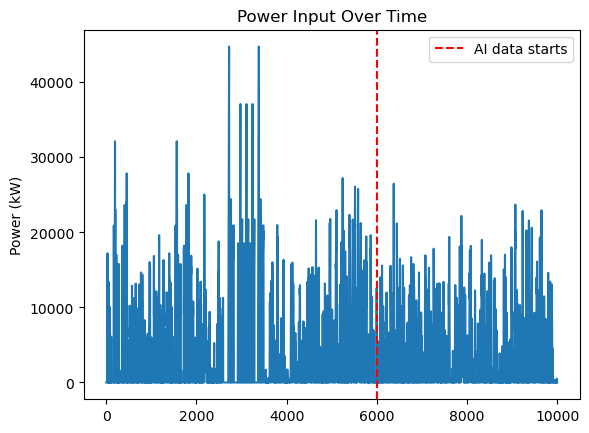

In [ ]:
plt.plot(power_input[:10000])
plt.axvline(6000, color='r', linestyle='--', label='AI data starts')
plt.title("Power Input Over Time")
plt.ylabel("Power (kW)")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (353208,) and (35320878,)

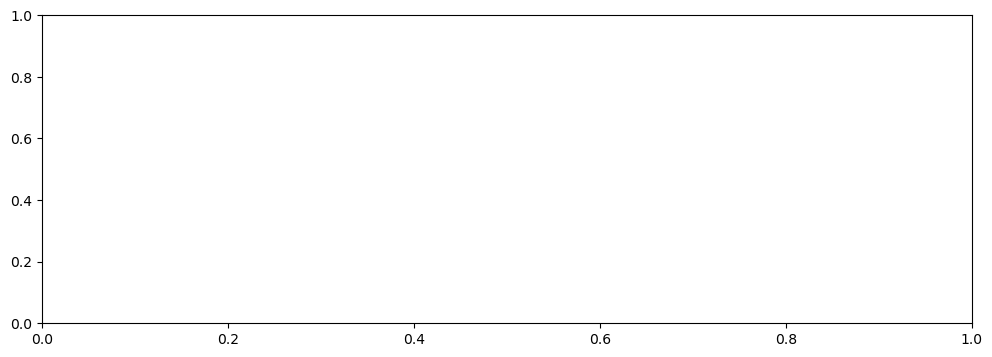

In [ ]:
plt.figure(figsize=(12, 4))
heat_regions = power_input * 1e-3  # from simulation
plt.plot(time, heat_regions, label="Heat Input (scaled)")
plt.title("Thermal Input Over Drive Cycle")
plt.xlabel("Time")
plt.ylabel("Relative Thermal Load")
plt.grid(True)
plt.legend()
plt.show()

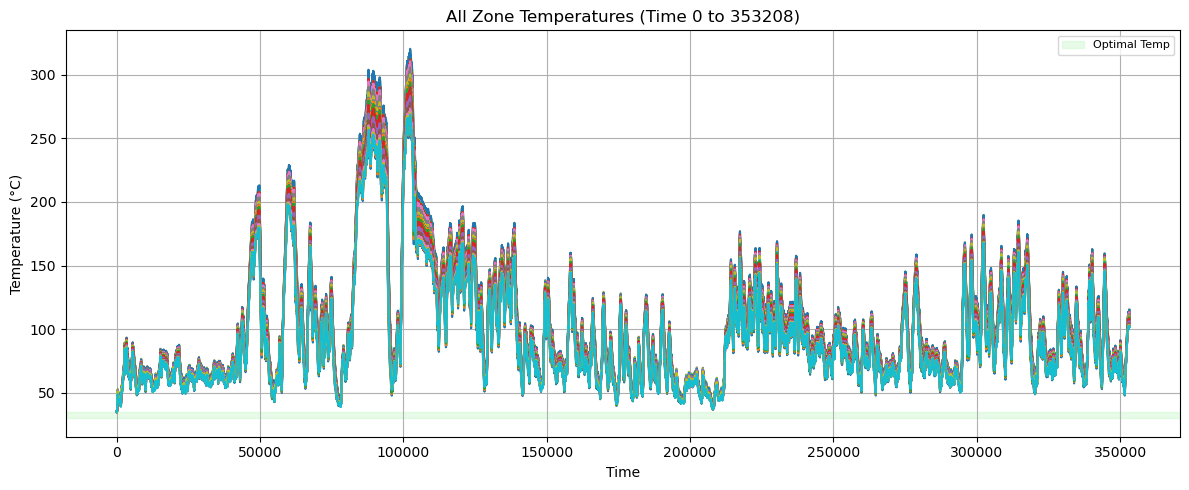

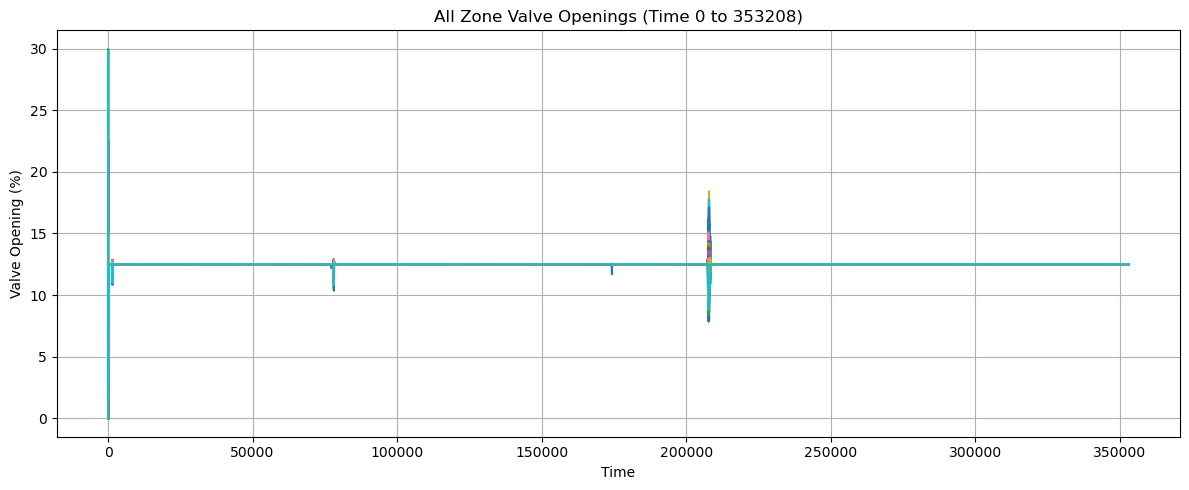

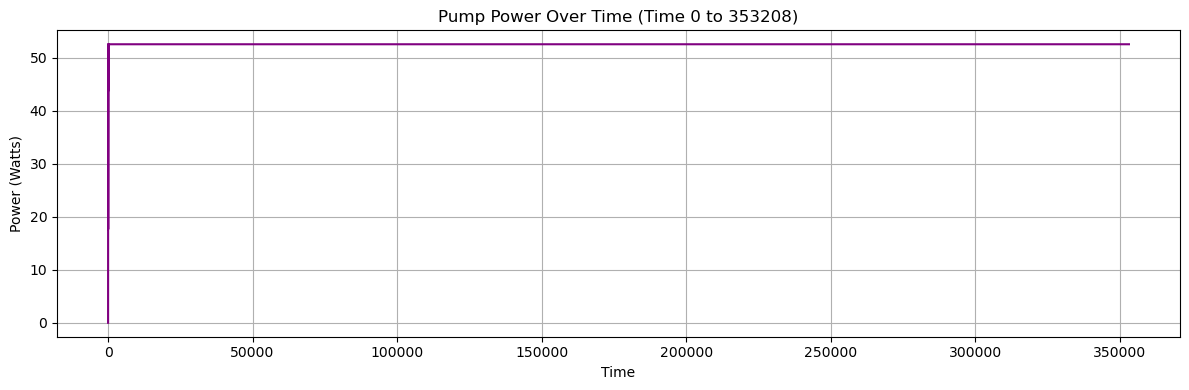

In [ ]:
# Time range selection (edit these values as needed)
start_time = 0
end_time = len(time)  # e.g., 0–500 steps, or len(time) for full

# Clamp range to safe bounds
start_time = max(0, start_time)
end_time = min(len(time), end_time)

# Slice the time range
t_range = slice(start_time, end_time)

# 🔥 Plot all zone temperatures
plt.figure(figsize=(12, 5))
plt.plot(time[t_range], temps[t_range, :])
plt.axhspan(30, 35, color='lightgreen', alpha=0.2, label="Optimal Temp")
plt.title(f"All Zone Temperatures (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

# 🔧 Plot all valve openings
plt.figure(figsize=(12, 5))
plt.plot(time[t_range], valves[t_range, :])
plt.title(f"All Zone Valve Openings (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Valve Opening (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ⚡ Plot pump power
plt.figure(figsize=(12, 4))
plt.plot(time[t_range], pump_power[t_range], color="purple")
plt.title(f"Pump Power Over Time (Time {start_time} to {end_time})")
plt.xlabel("Time")
plt.ylabel("Power (Watts)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df = pd.DataFrame({"Time": time})
for z in range(num_zones):
    df[f"ZoneTemp_{z+1}"] = temps[:, z]
    df[f"ValveOpen_{z+1}"] = valves[:, z]
df.to_csv("/home/keshav/Documents/reserch_code/simulated_battery_cooling.csv", index=False)
